# Tile Coding

### 0.Background: Automatically Discretization Scheme

In reinforcement learning, if you have prior knowledge about the state space, you can manually design an appropriate discretization scheme. For example, in the MountainCar scenario, we could design a specific discretization method, see previous [notebook](./discretization_mountaincar.ipynb). However, when dealing with unknown or arbitrary environments, a more generic method is required.

#### Tile Coding

Tile coding is an elegant discretization method that works well for continuous state spaces. The main steps and characteristics of tile coding are as follows:

1. **Overlaying Multiple Grids**  
   - In a continuous state space (e.g., a 2D space), multiple grids (called "tiles" or "tilings") are overlaid on top of each other.  
   - Each grid is slightly offset from the others to capture finer-grained information about the states.

2. **State Representation**  
   - Any position $ S $ in the state space can be coarsely identified by the tiles it activates.  
   - Each tile is assigned a binary bit: tiles that are activated are represented as 1, while inactive tiles are represented as 0.  
   - As a result, the state $ S $ can be represented as a sparse binary vector.

3. **Efficient State Value Representation**  
   - Instead of storing a separate value for each state $ V(S) $, the state value function is computed using the binary vector representation of the state and a weight for each tile.  
   - The tile coding algorithm iteratively updates these weights.

4. **Smoothing the Value Function**  
   - Since neighboring positions share some of the same tiles, their state values also share some weight components.  
   - This mechanism effectively smooths the learned value function.

#### Limitations of Tile Coding

- Tile sizes, offsets, and the number of tilings must be manually selected.  
- These hyperparameters can significantly affect the performance and learning outcomes.

#### Adaptive Tile Coding

To overcome the limitations of manually setting parameters, adaptive tile coding can be used. Its key features include:

1. **Dynamic Partitioning**  
   - Start with relatively large tiles.  
   - Split tiles into smaller sub-tiles when finer representations are needed.

2. **Splitting Conditions**  
   - Trigger splitting when the current representation is no longer effective for learning (e.g., when the value function stops changing significantly).  
   - Splitting stops when a predefined maximum number of splits or iterations is reached.

3. **Selecting Tiles to Split**  
   - Track sub-tiles and their projected weights to identify tiles that have the greatest impact on the value function.  
   - Choose the tile with the largest difference between sub-tile weights for splitting.

4. **Advantages**  
   - Adaptive tile coding does not rely on humans to specify the discretization scheme in advance.  
   - The resulting state space is automatically partitioned based on the complexity of the problem.

### 1. Import the Necessary Packages

In [1]:
# Import common libraries
import sys
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# for game rendering
import time
from PIL import Image
from IPython import display

from plot_utils import visualize_tilings, visualize_encoded_samples

# Set plotting options
%matplotlib inline
%config InlineBackend.figure_format='retina'
np.set_printoptions(precision=3, linewidth=120)

### 2. Explore Environment

<div style="text-align: center;">
    <img src="./images/acrobot.gif" alt="Mountain Car Environment" width="30%">
</div>

We'll use [OpenAI Gym Acrobot-v1](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/acrobot.py) environments to test and develop our algorithms. This environment have:

#### Continuous State Space

The observation is a `ndarray` with shape `(6,)` that provides information about the two rotational joint angles as well as their angular velocities:

| Num  | Observation                  | Min                 | Max               |
| ---- | ---------------------------- | ------------------- | ----------------- |
| 0    | Cosine of `theta1`           | -1                  | 1                 |
| 1    | Sine of `theta1`             | -1                  | 1                 |
| 2    | Cosine of `theta2`           | -1                  | 1                 |
| 3    | Sine of `theta2`             | -1                  | 1                 |
| 4    | Angular velocity of `theta1` | ~ -12.567 (-4 * pi) | ~ 12.567 (4 * pi) |
| 5    | Angular velocity of `theta2` | ~ -28.274 (-9 * pi) | ~ 28.274 (9 * pi) |

where

- `theta1` is the angle of the first joint, where an angle of 0 indicates the first link is pointing directly downwards.
- `theta2` is ***relative to the angle of the first link.*** An angle of 0 corresponds to having the same angle between the two links.

The angular velocities of `theta1` and `theta2` are bounded at ±4π, and ±9π rad/s respectively. A state of `[1, 0, 1, 0, ..., ...]` indicates that both links are pointing downwards.

#### Discrete Action Space

The action is discrete, deterministic, and represents the torque applied on the actuated joint between the two links.

| Num  | Action                                | Unit         |
| ---- | ------------------------------------- | ------------ |
| 0    | apply -1 torque to the actuated joint | torque (N m) |
| 1    | apply 0 torque to the actuated joint  | torque (N m) |
| 2    | apply 1 torque to the actuated joint  | torque (N m) |

In [2]:
env = gym.make('Acrobot-v1')

#### Random Agent

Run the next code cell to watch a random agent.

In [3]:
# Create an environment and set random seed
state, info = env.reset(seed=42)
score = 0
for t in range(200):
    action = env.action_space.sample()

    state, reward, done, _, _ = env.step(action)
    score += reward
    if done:
        break

print('Final score:', score)


Final score: -200.0


Explore the state and action spaces, as well as sample them.

In [4]:
# Explore state (observation) space
print("State space:\n", env.observation_space)
print(" - low:", env.observation_space.low)
print(" - high:", env.observation_space.high)

# Explore action space
print("Action space:\n", env.action_space)

print("-"*50)
# Generate some samples from the state space 
print("State space 10 samples:")
print(np.array([env.observation_space.sample() for i in range(10)]))

# Generate some samples from the action space
print("Action space 10 samples:")
print(np.array([env.action_space.sample() for i in range(10)]))

State space:
 Box([ -1.     -1.     -1.     -1.    -12.566 -28.274], [ 1.     1.     1.     1.    12.566 28.274], (6,), float32)
 - low: [ -1.     -1.     -1.     -1.    -12.566 -28.274]
 - high: [ 1.     1.     1.     1.    12.566 28.274]
Action space:
 Discrete(3)
--------------------------------------------------
State space 10 samples:
[[-3.437e-01 -8.008e-01 -4.368e-01 -5.740e-01  4.587e+00  8.053e+00]
 [-3.239e-02 -5.069e-01  1.542e-02 -2.859e-01 -1.128e+01  2.058e+01]
 [-8.117e-01 -6.361e-01 -1.239e-01  8.608e-01 -6.395e+00  9.587e+00]
 [ 3.923e-01  6.577e-01 -1.301e-01  1.453e-01  4.709e+00  2.104e+01]
 [ 7.010e-01  2.092e-01  4.305e-01 -6.450e-01  2.985e+00 -2.314e+01]
 [-2.575e-01  8.722e-01  1.400e-02 -6.969e-01  6.413e+00 -2.301e+01]
 [-3.137e-01  5.310e-01  4.375e-01 -8.212e-01 -1.226e+01  9.126e+00]
 [-4.687e-02  7.214e-01 -1.839e-01  4.987e-01  6.293e+00 -4.460e+00]
 [ 6.472e-01 -2.495e-01  1.342e-01 -3.073e-01  4.398e+00  2.500e+01]
 [ 6.546e-01  3.240e-01 -7.078e-01 -4

Note that the state space is multi-dimensional, with most dimensions ranging from -1 to 1 (positions of the two joints), while the final two dimensions have a larger range. How do we discretize such a space using tiles?

### 3. Tiling


#### Create Tiling Grid

Let's first design a way to create a single tiling for a given state space. This is very similar to a uniform grid! The only difference is that you should include an offset for each dimension that shifts the split points.

For instance, if we have
- `low = [-1.0, -5.0]`, 
- `high = [1.0, 5.0]`, 
- `bins = (10, 10)`,
- `offsets = (-0.1, 0.5)`, 

<div style="text-align: center;">
    <img src="./images/tile-coding.png" alt="Mountain Car Environment" width="70%">
</div>

then return a list of 2 NumPy arrays (2 dimensions) each containing the following split points (9 split points per dimension):

```
[array([-0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7]),
 array([-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5])]
```

Notice how the split points for the first dimension are offset by `-0.1`, and for the second dimension are offset by `+0.5`. 

<div style="text-align: center;">
    <img src="./images/tiling-grid.png" alt="Mountain Car Environment" width="70%">
</div>

This might mean that some of our tiles, especially along the perimeter, are partially outside the valid state space, but that is unavoidable and harmless.

In [5]:
def create_tiling_grid(low, high, bins=(10, 10), offsets=(0.0, 0.0)):
    """Define a uniformly-spaced grid that can be used for tile-coding a space.
    
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins or tiles along each corresponding dimension.
    offsets : tuple
        Split points for each dimension should be offset by these values.
    
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    grid = []
    for low, high, bin, offset in zip(low, high, bins, offsets):
        bin_size = (high - low) / bin
        grid.append(low + bin_size * np.arange(1, bin) + offset)
    return grid

low = [-1.0, -5.0]
high = [1.0, 5.0]
create_tiling_grid(low, high, bins=(10, 10), offsets=(-0.1, 0.5))  # [test]

[array([-0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7]),
 array([-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5])]

Now use this function to define a set of tilings that are a little offset from each other.

In [6]:
def create_tilings(low, high, tiling_specs):
    """Define multiple tilings using the provided specifications.

    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    tiling_specs : list of tuples
        A sequence of (bins, offsets) to be passed to create_tiling_grid().

    Returns
    -------
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    """
    tilings = []
    for bins, offsets in tiling_specs:
        tilings.append(create_tiling_grid(low, high, bins, offsets))
    return tilings


# Tiling specs: [(<bins>, <offsets>), ...]
tiling_specs = [((10, 10), (-0.066, -0.33)),
                ((10, 10), (0.0, 0.0)),
                ((10, 10), (0.066, 0.33))]
tilings = create_tilings(low, high, tiling_specs)
tilings

[[array([-0.866, -0.666, -0.466, -0.266, -0.066,  0.134,  0.334,  0.534,  0.734]),
  array([-4.33, -3.33, -2.33, -1.33, -0.33,  0.67,  1.67,  2.67,  3.67])],
 [array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
  array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])],
 [array([-0.734, -0.534, -0.334, -0.134,  0.066,  0.266,  0.466,  0.666,  0.866]),
  array([-3.67, -2.67, -1.67, -0.67,  0.33,  1.33,  2.33,  3.33,  4.33])]]

#### Visualize Tiling Grid
It may be hard to gauge whether you are getting desired results or not. So let's try to visualize these tilings.

<Axes: title={'center': 'Tilings'}>

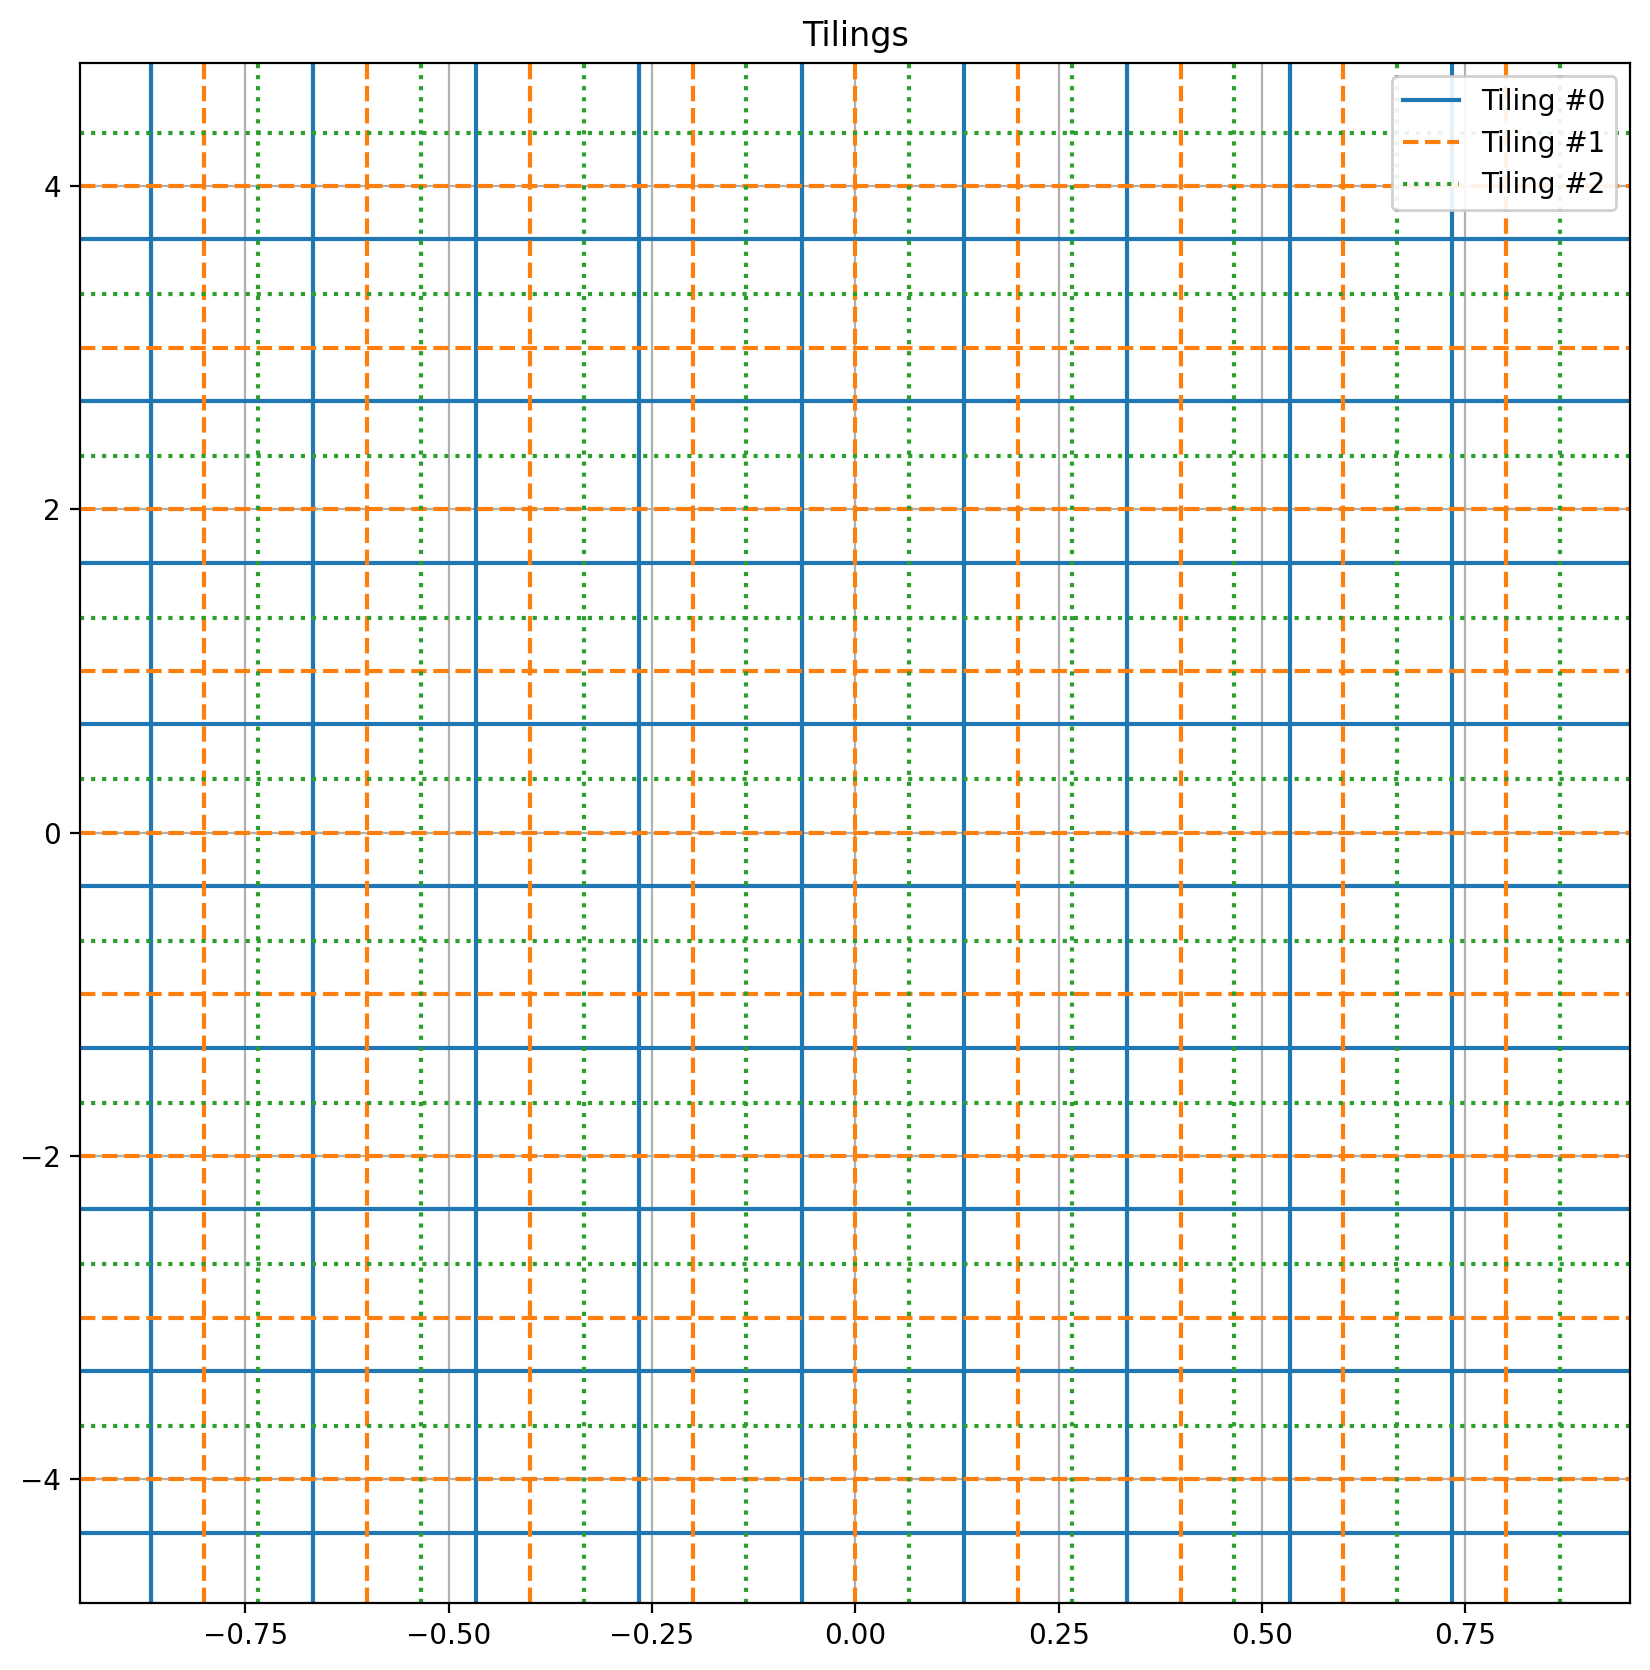

In [7]:
visualize_tilings(tilings)

#### State Space From Continous to Discreate

Now that we have a way to generate these tilings, we can next write our encoding function that will convert any given continuous state value to a discrete vector.

Below function is to produce a vector that contains the indices for each tile that the input state value belongs to. The shape of the vector can be the same as the arrangment of tiles, or it can be ultimately flattened for convenience.

Similarly, for each tile we can use the [`numpy.digitize()`](https://docs.scipy.org/doc/numpy-1.9.3/reference/generated/numpy.digitize.html) function for this purpose.

Assume the grid is a list of NumPy arrays containing the following split points:
```
[array([-0.8, -0.6, -0.4, -0.2,  0.0,  0.2,  0.4,  0.6,  0.8]),
 array([-4.0, -3.0, -2.0, -1.0,  0.0,  1.0,  2.0,  3.0,  4.0])]
```

Here are some potential samples and their corresponding discretized representations:
```
[-1.0 , -5.0] => [0, 0]
[-0.81, -4.1] => [0, 0]
[-0.8 , -4.0] => [1, 1]
[-0.5 ,  0.0] => [2, 5]
[ 0.2 , -1.9] => [6, 3]
[ 0.8 ,  4.0] => [9, 9]
[ 0.81,  4.1] => [9, 9]
[ 1.0 ,  5.0] => [9, 9]
```

Finally, we use the same `discretize()` function here from grid-based discretization, and simply call it for each tiling.

In [43]:
def discretize(sample, grid):
    """Discretize a sazmple as per given grid.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """
    return tuple(np.digitize(s, g) for s, g in zip(sample, grid))


def tile_encode(sample, tilings, flatten=False):
    """Encode given sample using tile-coding.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    flatten : bool
        If true, flatten the resulting binary arrays into a single long vector.

    Returns
    -------
    encoded_sample : list or array_like
        A list of binary vectors, one for each tiling, or flattened into one.
    """
    encoded_sample = np.array(
        [discretize(sample, grid) for grid in tilings]
    )
    if flatten:
        encoded_sample = np.concatenate(encoded_sample)
    return encoded_sample

    

# Test with some sample values on 2D space
# Reminder: in acrobot problem we have 6 dim in each sample
samples = [(-1.2 , -5.1 ),
           (-0.75,  3.25),
           (-0.5 ,  0.0 ),
           ( 0.25, -1.9 ),
           ( 0.15, -1.75),
           ( 0.75,  2.5 ),
           ( 0.7 , -3.7 ),
           ( 1.0 ,  5.0 )]
encoded_samples = [tile_encode(sample, tilings, flatten=False) for sample in samples]
for sample, encoded in zip(samples, encoded_samples):
    print(f"{sample} \t=> ", end="")
    if len(encoded) == len(tilings):
        for i, enc in enumerate(encoded):
            print(f" tile {i} : {enc}, ", end="")
        print()
    else:
        print(encoded)

(-1.2, -5.1) 	=>  tile 0 : [0 0],  tile 1 : [0 0],  tile 2 : [0 0], 
(-0.75, 3.25) 	=>  tile 0 : [1 8],  tile 1 : [1 8],  tile 2 : [0 7], 
(-0.5, 0.0) 	=>  tile 0 : [2 5],  tile 1 : [2 5],  tile 2 : [2 4], 
(0.25, -1.9) 	=>  tile 0 : [6 3],  tile 1 : [6 3],  tile 2 : [5 2], 
(0.15, -1.75) 	=>  tile 0 : [6 3],  tile 1 : [5 3],  tile 2 : [5 2], 
(0.75, 2.5) 	=>  tile 0 : [9 7],  tile 1 : [8 7],  tile 2 : [8 7], 
(0.7, -3.7) 	=>  tile 0 : [8 1],  tile 1 : [8 1],  tile 2 : [8 0], 
(1.0, 5.0) 	=>  tile 0 : [9 9],  tile 1 : [9 9],  tile 2 : [9 9], 


#### Visualize Discretized State Space

Note that we did not flatten the encoding above, which is why each sample's representation is a pair of indices for each tiling. This makes it easy to visualize it using the tilings.

<Axes: title={'center': 'Tile-encoded samples'}>

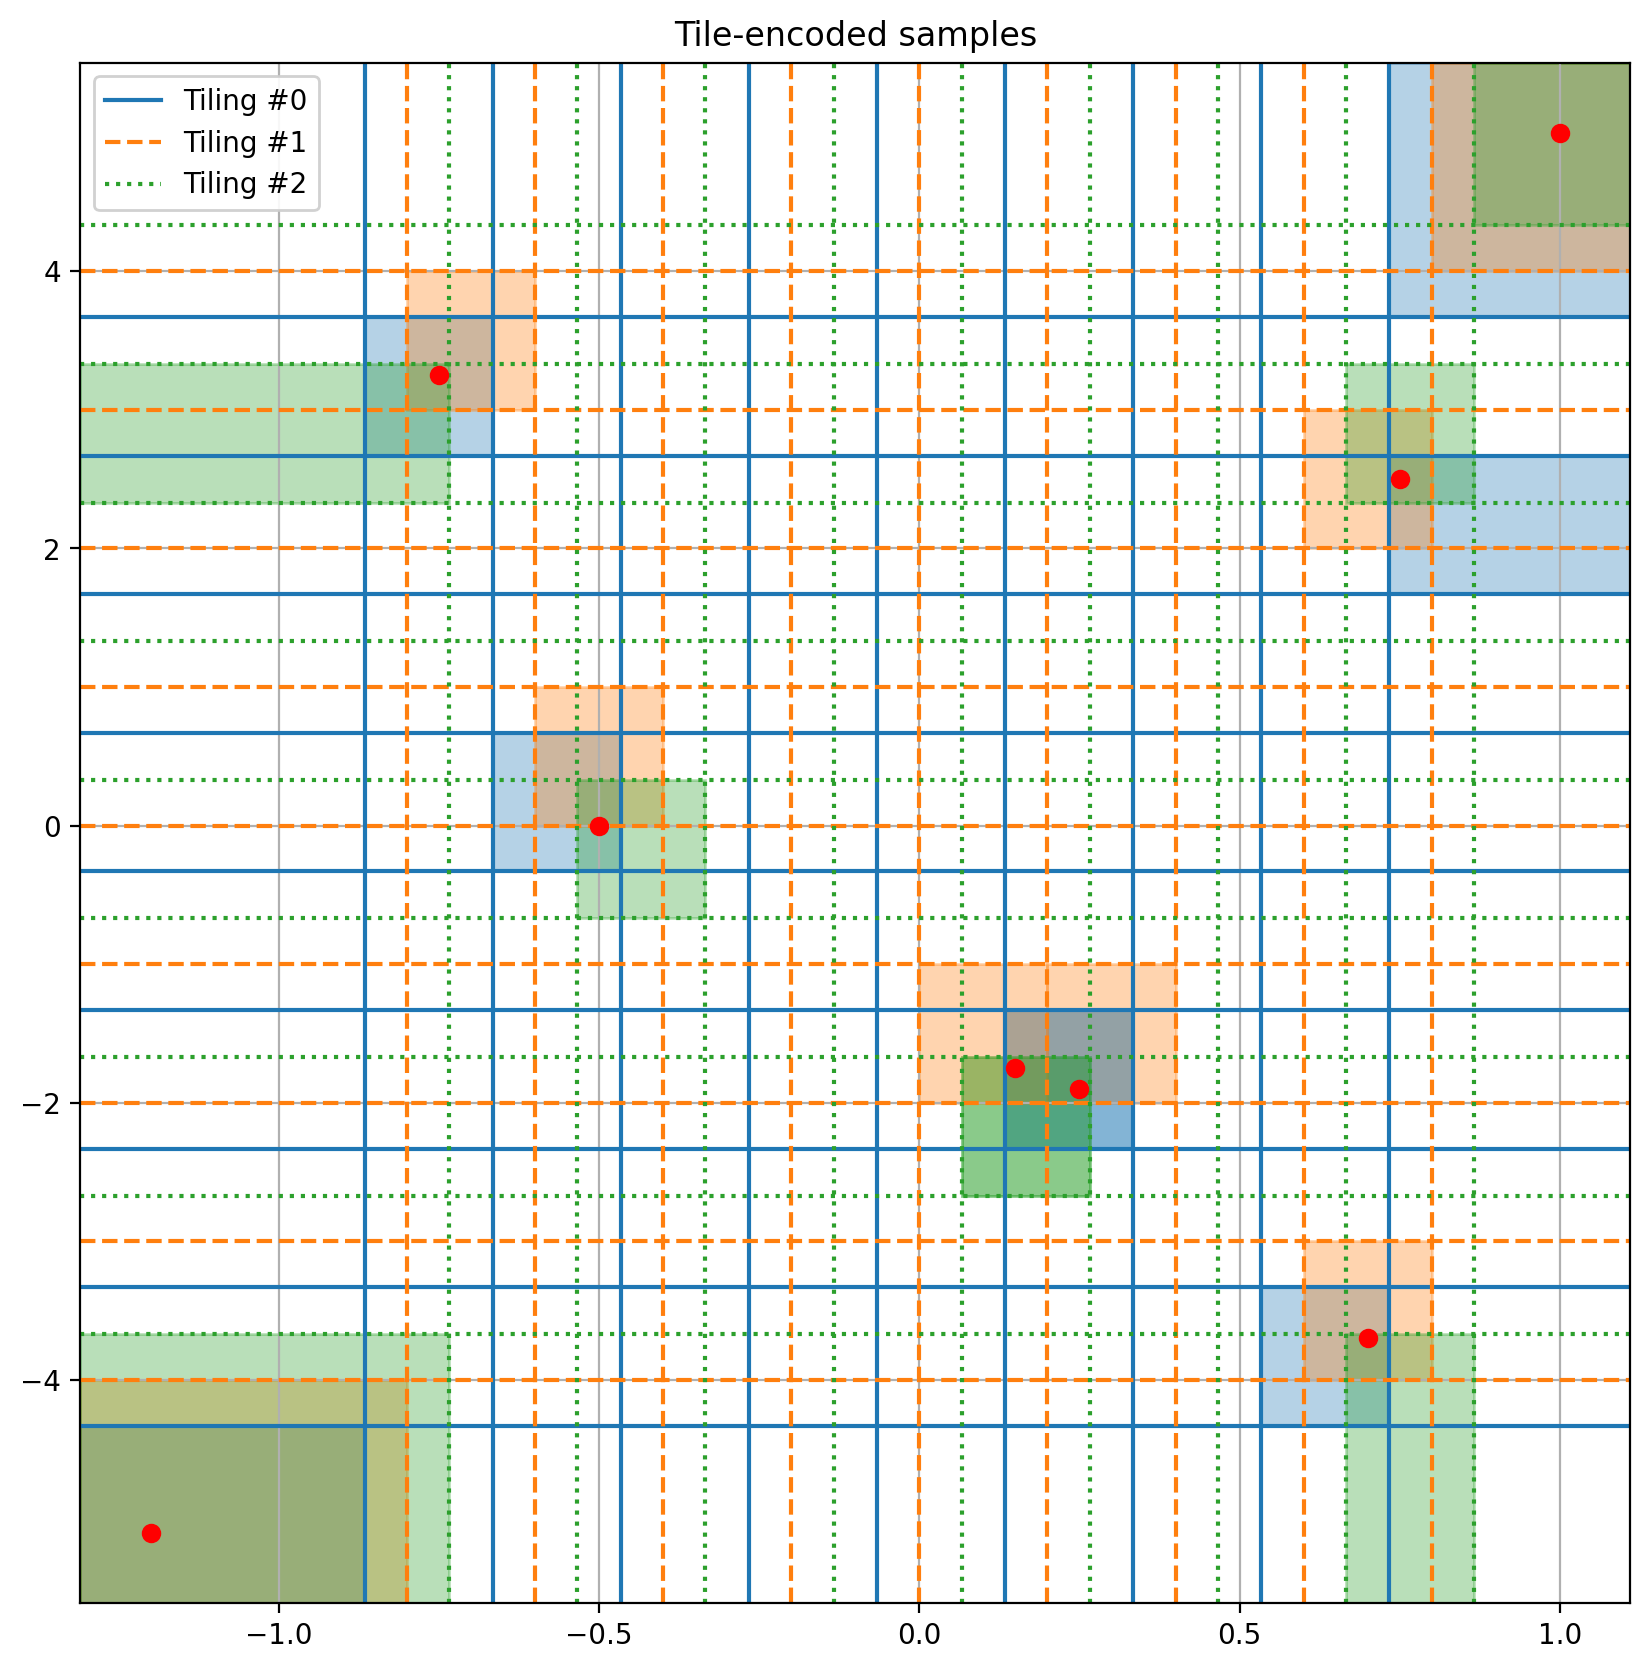

In [44]:
visualize_encoded_samples(samples, encoded_samples, tilings)

Inspect the results, we can see:
   - Any position $ S $ in the state space can be coarsely identified by the tiles it activates.  
   - Each tile is assigned a binary bit: tiles that are activated and then given indice corresponding with specific tile, while inactive tiles are represented as 0.  

### 4. Q-Table with Tile Coding

The next step is to design a special Q-table that is able to utilize this tile coding scheme. It  have the same kind of interface as a regular table, i.e. given a `<state, action>` pair, it return a `<value>`. Similarly, it also allow update the `<value>` for a given `<state, action>` pair (note that this should update all the tiles that `<state>` belongs to).

In contrast to previous [uniform discretization method](./discretization_mountaincar.ipynb), we use matrix instead of dict to represent Q table, for vectorize computation convience.

The `<state>` supplied here is assumed to be from the original continuous state space, and `<action>` is discrete (and integer index). The Q-table should internally convert the `<state>` to its tile-coded representation when required.

In [65]:
class QTable:
    """Simple Q-table."""

    def __init__(self, state_size, action_size):
        """Initialize Q-table.
        
        Parameters
        ----------
        state_size : tuple
            Number of discrete values along each dimension of state space.
        action_size : int
            Number of discrete actions in action space.
        """
        self.state_size = state_size
        self.action_size = action_size

        # Create Q-table, initialize all Q-values to zero
        # Note: If state_size = (9, 9), action_size = 2, q_table.shape should be (9, 9, 2)
        self.Q = np.zeros((*state_size, action_size))
        print(f"Q table size = {self.Q.shape}")

QTable((9, 9), 2)

Q table size = (9, 9, 2)


In [116]:
class TiledQTable:
    """Composite Q-table with an internal tile coding scheme."""
    
    def __init__(self, low, high, tiling_specs, action_size):
        """Create tilings and initialize internal Q-table(s).
        
        Parameters
        ----------
        low : array_like
            Lower bounds for each dimension of state space.
        high : array_like
            Upper bounds for each dimension of state space.
        tiling_specs : list of tuples
            A sequence of (bins, offsets) to be passed to create_tilings() along with low, high.
        action_size : int
            Number of discrete actions in action space.
        """
        self.tilings_grid = create_tilings(low, high, tiling_specs)
        self.state_sizes = [tuple(len(splits)+1 for splits in grid) 
                            for grid in self.tilings_grid]
        self.action_size = action_size
        self.q_tables = [QTable(state_size, self.action_size) for state_size in self.state_sizes]
        print("TiledQTable(): no. of internal tables = ", len(self.q_tables))

    def __len__(self):
        return len(self.q_tables)

    def __getitem__(self, index):
        return self.q_tables[index].Q
    
    def get(self, state, action):
        """Get Q-value for given <state, action> pair.
        
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        action : int
            Index of desired action.
        
        Returns
        -------
        value : float
            Q-value of given <state, action> pair, averaged from all internal Q-tables.
        """
        # Encode state to get tile indices
        states = tile_encode(state, self.tilings_grid)

        q = 0.
        for i, state in enumerate(states):
            # Retrieve q-value for each tiling, and return their average
            q += self.q_tables[i].Q[(*state, action)]
        return q / len(self.q_tables)

    def update(self, state, action, value, alpha=0.1):
        """Soft-update Q-value for given <state, action> pair to value.
        
        Instead of overwriting Q(state, action) with value, perform soft-update:
            Q(state, action) = alpha * value + (1.0 - alpha) * Q(state, action)
        
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        action : int
            Index of desired action.
        value : float
            Desired Q-value for <state, action> pair.
        alpha : float
            Update factor to perform soft-update, in [0.0, 1.0] range.
        """
        # Encode state to get tile indices
        states = tile_encode(state, self.tilings_grid)
        
        # Update q-value for each tiling by update factor alpha
        for i, state in enumerate(states):
            curr_q = self.q_tables[i].Q[(*state, action)]
            self.q_tables[i].Q[(*state, action)] = curr_q + alpha * (value - curr_q)

        
print(f"Create {len(tiling_specs)} tiling grids based on:\n {tiling_specs}")
# Test with a sample Q-table
Qs = TiledQTable(low, high, tiling_specs, 2)
s1 = 3; s2 = 4; a = 0; q = 1.0
# check value at sample = s1, state = samples[s1], action = a
print("[GET]    Q({}, {}) = {}".format(samples[s1], a, Qs.get(samples[s1], a)))
# update value for sample with some common tile(s)
print("[UPDATE] Q({}, {}) = {}".format(samples[s1], a, q)); Qs.update(samples[s1], a, q)
# check value again, should be slightly updated
print("[GET]    Q({}, {}) = {}".format(samples[s2], a, Qs.get(samples[s2], a)))

Create 3 tiling grids based on:
 [((10, 10), (-0.066, -0.33)), ((10, 10), (0.0, 0.0)), ((10, 10), (0.066, 0.33))]
Q table size = (10, 10, 2)
Q table size = (10, 10, 2)
Q table size = (10, 10, 2)
TiledQTable(): no. of internal tables =  3
[GET]    Q((0.25, -1.9), 0) = 0.0
[UPDATE] Q((0.25, -1.9), 0) = 1.0
[GET]    Q((0.15, -1.75), 0) = 0.06666666666666667


If you update the q-value for a particular state (say, `(0.25, -1.91)`) and action (say, `0`), then you should notice the q-value of a nearby state (e.g. `(0.15, -1.75)` and same action) has changed as well! This is how tile-coding is able to generalize values across the state space better than a single uniform grid.

### 5. Q-Learning (or SARSA Max) using Tile-Coding

In [124]:
class QLearningAgent:

    def __init__(
        self,
        env,
        tiling_specs,
        epsilon=1.0,
        alpha=0.02,
        gamma=0.99,
        eps_decay=0.9995,
        eps_min=0.01,
        seed=505,
    ):
        """Initialize agent.

        Params
        ======
        - state_grid: discretized state space
        - nA: number of actions available to the agent

        """
        self.seed = np.random.seed(seed)

        low = env.observation_space.low
        high = env.observation_space.high
        self.nA = env.action_space.n

        # Create Q-table
        self.Qs = TiledQTable(low, high, tiling_specs, self.nA)

        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # initial exploration rate
        self.eps_decay = eps_decay  # how quickly should we decrease epsilon
        self.eps_min = eps_min

    def __repr__(self):
        return (
            f"{len(self.Qs)} tiles, each tile:\n"
            f"State space size: {self.Qs[0].shape[:-1]}\n"
            f"Action space size: {self.nA}"
        )

    def select_action(self, state):
        """Given the state, select an action.

        Params
        ======
        - state: the current state of the environment

        Returns
        =======
        - action: an integer, compatible with the task's action space
        """
        self.epsilon *= self.eps_decay
        self.epsilon = max(self.epsilon, self.eps_min)

        do_exploration = np.random.random() < self.epsilon
        if do_exploration:
            return np.random.choice(np.arange(self.nA))
        else:
            return np.argmax(self.Qs.get(state, None))

    def step(self, state, action, reward, next_state, done, mode="train"):
        """Update the agent's knowledge, using the most recently sampled tuple.

        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        """
        if mode == "test":
            # Test mode: Simply produce an action
            return np.argmax(self.Qs.get(state, None))
        else:
            if done:
                self.Qs.update(state, action, reward, self.alpha)
            else:
                G_estimate = reward + self.gamma * np.max(self.Qs.get(next_state, None))
                self.Qs.update(state, action, G_estimate, self.alpha)


def interact(env, agent, num_episodes=20000, window=100, mode="train"):
    """Monitor agent's performance.

    Params
    ======
    - env: instance of OpenAI Gym's(maintained by gymnasium) mountain car environment
    - agent: instance of class Agent (see Agent.py for details)
    - num_episodes: number of episodes of agent-environment interaction
    - window: number of episodes to consider when calculating average rewards

    Returns
    =======
    - scores: list containing average rewards
    - max_avg_score: largest value in the scores list
    """

    # initialize best average reward
    max_avg_score = -np.inf

    # initialize monitor for most recent rewards
    scores = []

    # for each episode
    for i_episode in range(1, num_episodes + 1):
        # begin the episode
        state, _ = env.reset()

        # initialize the sampled reward
        total_reward = 0
        while True:
            # agent selects an action
            action = agent.select_action(state)

            # agent performs the selected action
            next_state, reward, done, _, _ = env.step(action)

            # agent performs internal updates based on sampled experience
            agent.step(state, action, reward, next_state, done)

            # update the sampled reward
            total_reward += reward

            # update the state (s <- s') to next time step
            state = next_state

            if done:
                # save final sampled reward
                scores.append(total_reward)
                break

        if mode == "train":
            # Print episode stats
            if len(scores) > window:
                avg_score = np.mean(scores[-window:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score

            if i_episode % window == 0:
                print(
                    "\rEpisode {}/{} | Max Average Score: {}".format(
                        i_episode, num_episodes, max_avg_score
                    ),
                    end="",
                )
                sys.stdout.flush()

            if i_episode == num_episodes:
                print("\n")
    return scores


n_bins = 5
bins = tuple([n_bins]*env.observation_space.shape[0])
offset_pos = (env.observation_space.high - env.observation_space.low)/(3*n_bins)

tiling_specs = [(bins, -offset_pos),
                (bins, tuple([0.0]*env.observation_space.shape[0])),
                (bins, offset_pos)]

agent = QLearningAgent(
    env,
    tiling_specs,
    epsilon=1.0,
    alpha=0.02,
    gamma=0.99,
    eps_decay=0.9995,
    eps_min=0.01,
    seed=505,
)
agent

Q table size = (5, 5, 5, 5, 5, 5, 3)
Q table size = (5, 5, 5, 5, 5, 5, 3)
Q table size = (5, 5, 5, 5, 5, 5, 3)
TiledQTable(): no. of internal tables =  3


3 tiles, each tile:
State space size: (5, 5, 5, 5, 5, 5)
Action space size: 3

#### Training

In [125]:
scores = interact(env, agent, num_episodes=20000, window=100, mode='train')

Episode 20000/20000 | Max Average Score: -211.92



#### Visualize Learning curve

The best way to analyze if agent was learning the task is to plot the scores. It should generally increase as the agent goes through more episodes.

If scores are noisy, it might be difficult to tell whether agent is actually learning. To find the underlying trend, we also want to plot a rolling mean of the scores.

As below figure showed, the mean episode scores go up over time.

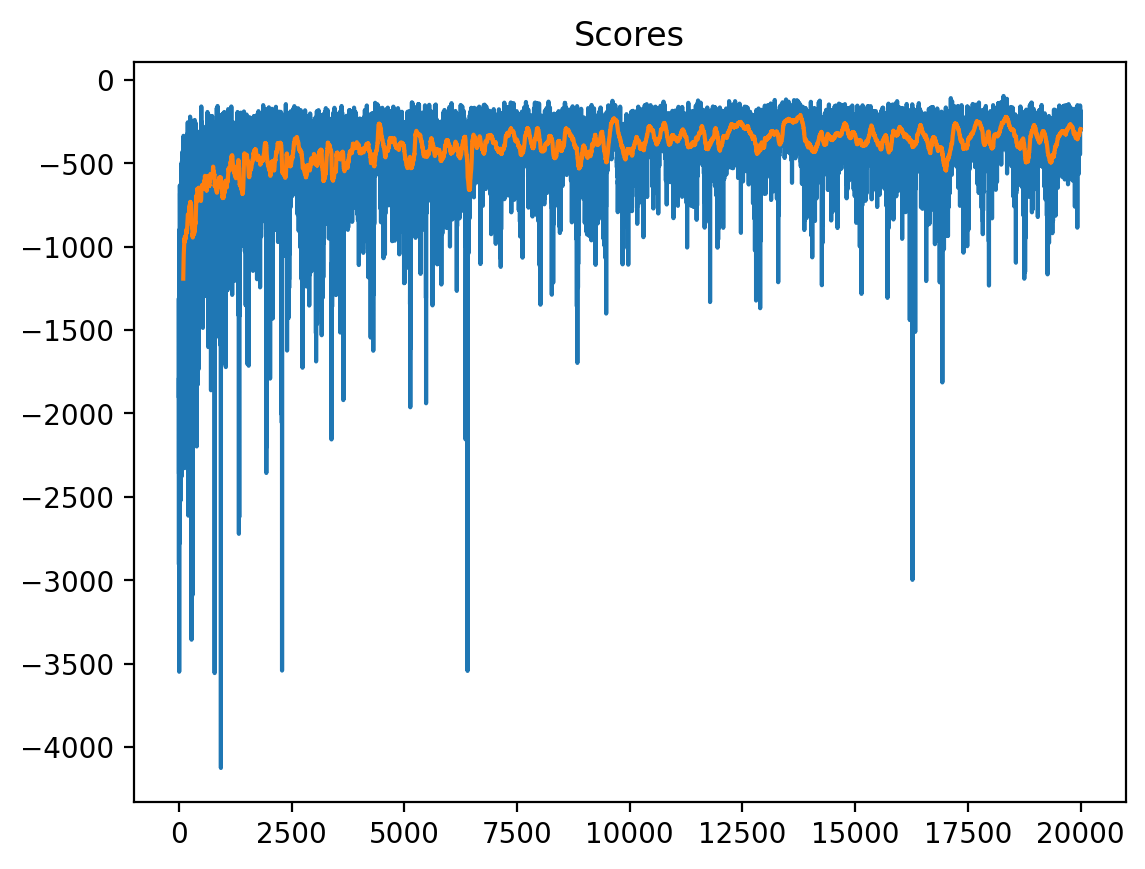

In [126]:
from plot_utils import plot_scores
rolling_mean = plot_scores(scores)

#### Testing

Next, we freeze the agent and run the agent in test mode to see how well it performs.

Test Completed on 100 episodes with avg. score = -279.49


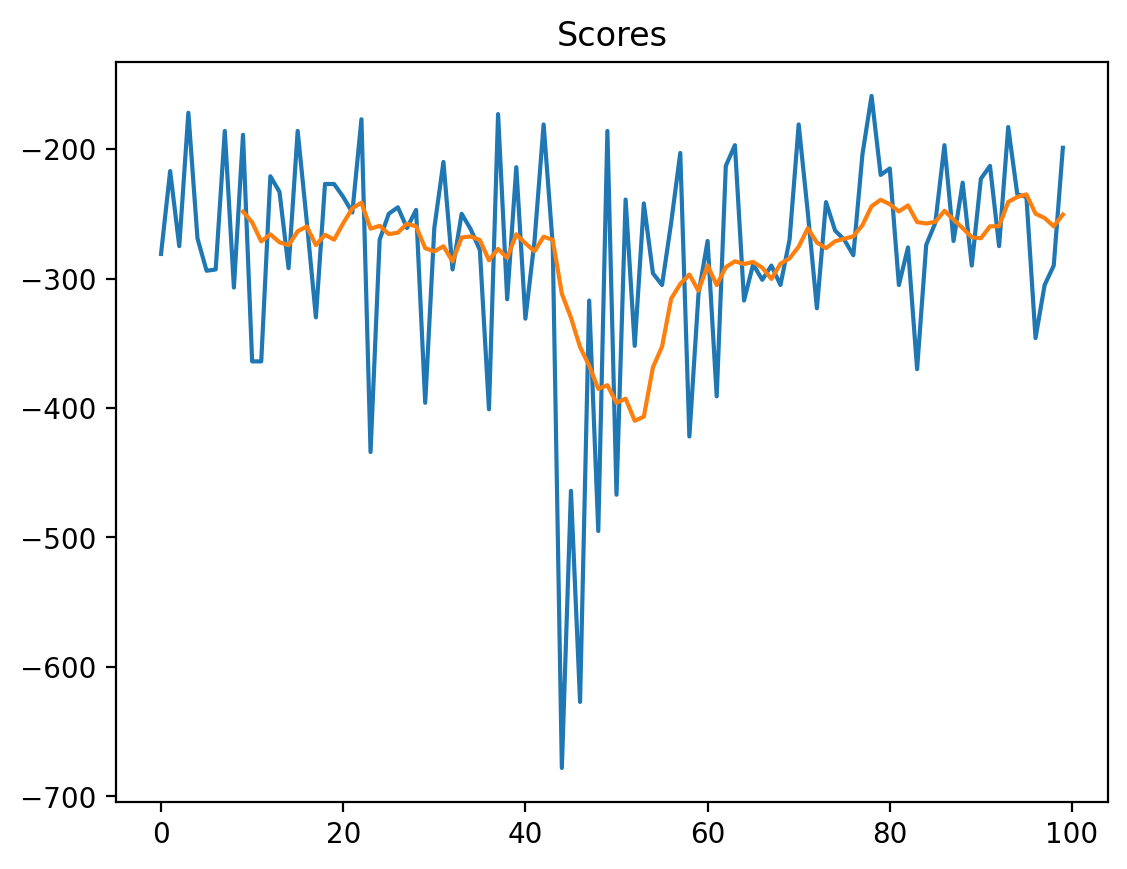

In [127]:
# Run in test mode and analyze scores obtained
test_scores = interact(env, agent, num_episodes=100, mode="test")
print(
    f"Test Completed on {len(test_scores)} episodes with avg. score = {np.mean(test_scores)}"
)
_ = plot_scores(test_scores, rolling_window=10)

### 6. Watch a Smart Agent

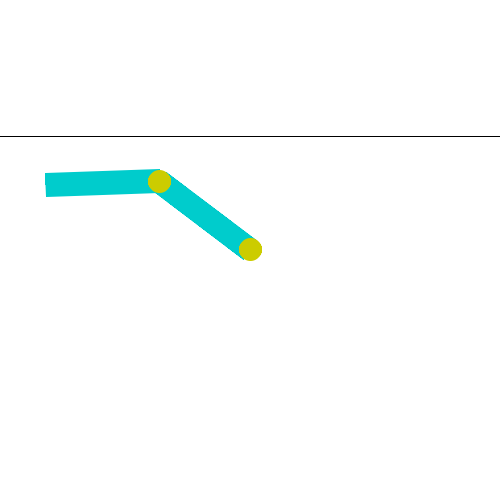

Final score: -328.0


: 

In [131]:
env = gym.make('Acrobot-v1', render_mode="rgb_array")

state, info = env.reset(seed=42)
score = 0
for t in range(500):
    # clear frame
    display.clear_output(wait=True)

    action = agent.step(state, None, None, None, None, mode='test')

    # render game
    frame = env.render()
    display.display(Image.fromarray(frame))
    time.sleep(0.05)

    state, reward, done, _, _ = env.step(action)
    score += reward
    if done:
        break

print('Final score:', score)
env.close()

The Acrobot is a two-link pendulum system with one fixed joint and one actuated joint. The training objective is to control the torque applied at the actuated joint to swing the system such that the end of the second link reaches or exceeds the target height (above the horizontal line). This agent using Q-learning with tile coding succucessfully solve nonlinear dynamic problems by leveraging momentum and coordination between the links.

### Discussion: from traditional RL to Deep RL

Yes, we can definitely use tile-coding or uniform discretization methods to convert continuous space into a discrete one, but these methods have some limitations. For example:

- **Curse of Dimensionality**: As the dimensionality of the state space increases, the number of discrete states grows exponentially, making it computationally expensive to store and update the value function.
- **Loss of Precision**: Discretization can lead to a loss of information about the underlying continuous dynamics, which may result in suboptimal policies, especially when the resolution of discretization is coarse.
- **Fixed Representation**: Once the discretization granularity is chosen, it cannot adapt dynamically to the complexity of different regions in the state space, leading to either inefficiencies or insufficient detail.

#### Parameterized Function Approximation
To overcome these limitations, instead of discretizing the space, we can use a parameterized function to approximate the true value function:

$$
\hat{v}(s, w) \approx v_\pi(s)
$$
$$
\hat{q}(s, a, w) \approx q_\pi(s, a)
$$

Because, for a problem domain with continuous state space $ s \in S = \mathbb{R}^n $, we aim to represent the value function $ v_\pi(s) $ (for prediction) or $ q_\pi(s, a) $ (for control).

#### Feature Vectors
A common intermediate step involves computing a feature vector $ x(s) $ that represents the state in a way suitable for function approximation. This allows the parameterized function to generalize across the continuous state space, enabling efficient learning and better scalability to high-dimensional problems.

Using this method of extending linear function approximation helps us capture the non-linear relationships between input states and output values. The core idea is achieved through **feature transformation**.

Feature transformation is a process that converts a state $ s $, or a state-action pair $ (s, a) $, into a feature vector $ x(s) $.  

Each element of the feature vector can be generated by an individual function, which may be non-linear.

for example, assume the state $ s $ is a real number. We can define a set of non-linear feature functions:

$$
x_1(s) = s
$$
$$
x_2(s) = s^2
$$
$$
x_3(s) = s^3
$$
$$
\text{and so on...}
$$

Radial Basis Functions are a common type of kernel function:

- The current state $ s $ is treated as a point in the continuous state space.
- Each basis function corresponds to a "fuzzy region" (or "blob"), centered around a specific point in the state space.
- The closer the state is to the center of the basis function, the higher the response value. As the distance increases, the response value gradually decreases.

which are typically defined using a Gaussian kernel

$$
\phi(s) = \exp\left(-\frac{\|s - \mu\|^2}{2\sigma^2}\right)
$$

Where:
- $ \mu $ is the center of the basis function.
- $ \sigma $ determines how quickly the response value decays as the distance increases.


Given a state $ s $, we can use multiple radial basis functions to generate a feature vector:

$$
x(s) = [\phi_1(s), \phi_2(s), \dots, \phi_k(s)]
$$

Although non-linear feature transformations are used, the resulting value function is still a linear combination of these features:

$$
\hat{v}(s, w) = w_1 x_1(s) + w_2 x_2(s) + w_3 x_3(s) + \dots
$$

This means that we can still use linear function approximation methods(see below) while capturing non-linear relationships through feature transformations.

But, in this situation, we still use a linear function approximation for $\hat{v}(s, w)$, what if we completly using non-linear behavior of input $x(s)$ and $\hat{v}(s, w)$, yes, we can pass linear response (dot product of weights and features) through a non-linear activation function. This approach forms the foundation of artificial neural networks, where the activation function significantly enhances the representational power of the approximator.

#### Learning Parameters $ w $

Our objective is then to determine a set of parameters $ w $ that produces an optimal value function. This can be accomplished using the general reinforcement learning framework, employing either Monte Carlo or Temporal-Difference (TD) methods. The update mechanism is adjusted based on the chosen parameterized function:

1. **Monte Carlo Methods**:  
   - Use the complete trajectory's return $ G_t $ to update the parameters.
   - Often works well but can be slow due to high variance and the need to wait until the end of an episode.

2. **Temporal-Difference (TD) Methods**:  
   - Use the TD target $ r + \gamma \hat{v}(s', w) $ as an estimate of $ v_\pi(s) $ to update the parameters.
   - More efficient and widely used in practice, as it updates parameters incrementally without waiting for the episode to finish.

The update rule for $ w $ is generally of the form:
$$
w \leftarrow w + \alpha \delta x(s)
$$
where:
- $ \delta $ is the TD error:  
  $$
  \delta = r + \gamma \hat{v}(s', w) - \hat{v}(s, w)
  $$
- $ x(s) $ is the feature vector for the state $ s $.

#### Applications in Continuous Action Spaces

In problems with **continuous action spaces**, parameterized functions are also used to approximate the policy directly. For example:
- Instead of choosing the best action $ a^* $ by iterating over all possible actions (as in discrete action spaces), the model directly outputs the optimal action $ a^* $ using a parameterized policy $ \pi_\theta(s) $:
  $$
  a^* = \pi_\theta(s)
  $$
- This is particularly useful in tasks like robotics and autonomous driving, where actions such as steering angle or throttle are continuous variables.
